In [1]:
from utz import *
import plotly.express as px
import plotly.graph_objects as go
from ire import export, MD

[Papermill](https://papermill.readthedocs.io/) params:

In [2]:
region = None  # ⊆ {NYC,JC,HOB}, comma-delimited

In [3]:
# Parameters
region = "jc,hob"


In [4]:
all_regions = [ 'NYC', 'JC', 'HOB' ]
regions = region.upper().split(',') if region else all_regions
name_suffix = '' if regions == all_regions else '-'.join([''] + [ r.lower() for r in regions ])

In [5]:
regions_str = "" if regions == all_regions else f" – {', '.join(regions)}"
MD(f"""
# Citi Bike Rides by Month{regions_str}

Subtotals, factored by:
- region (NYC, JC, HOB)
- month/year
- gender (until Feb '21)
- bike ("rideable") type
- number of rides ("Count")
- duration of rides ("Duration")
""", id="rides")


# Citi Bike Rides by Month – JC, HOB

Subtotals, factored by:
- region (NYC, JC, HOB)
- month/year
- gender (until Feb '21)
- bike ("rideable") type
- number of rides ("Count")
- duration of rides ("Duration")


In [6]:
ymrgtb_cd = read_json('../www/public/assets/ymrgtb_cd.json')
ymrgtb_cd['Date'] = ymrgtb_cd[['Year', 'Month']].apply(lambda r: date(r.Year, r.Month, 1), axis=1)
genders = ['Unknown', 'Male', 'Female']
ymrgtb_cd['Gender'] = pd.Categorical(ymrgtb_cd['Gender'].apply(lambda g: genders[g]), categories=genders, ordered=False)
agg = ymrgtb_cd[ymrgtb_cd.Region.isin(regions)]
export(
    agg.drop(columns=['Year', 'Month']).set_index('Date'),
    name=f'ymrgtb_cd{name_suffix}',
    fmts={'Date': '%Y-%m'},
    per_page=20,
)

Saved parquet to .ire/ymrgtb_cd-jc-hob.parquet


In [7]:
agg.groupby('Rideable Type').Count.sum()

Rideable Type
classic_bike     2173981
docked_bike       141872
electric_bike     983024
unknown          1688712
Name: Count, dtype: int64

In [8]:
rides = agg.groupby('Date')['Count'].sum()
rides

Date
2015-09-01      6668
2015-10-01     19264
2015-11-01     15113
2015-12-01     11838
2016-01-01      7479
               ...  
2024-05-01     97191
2024-06-01    110718
2024-07-01    111978
2024-08-01    106056
2024-09-01    115267
Name: Count, Length: 109, dtype: int64

In [9]:
agg_12mo = round(rides.rolling(12).mean()).dropna()
agg_12mo

Date
2016-08-01    16698.0
2016-09-01    18917.0
2016-10-01    19775.0
2016-11-01    20331.0
2016-12-01    20600.0
2017-01-01    21053.0
2017-02-01    21529.0
2017-03-01    21418.0
2017-04-01    21824.0
2017-05-01    22364.0
2017-06-01    23041.0
2017-07-01    23803.0
2017-08-01    23918.0
2017-09-01    23902.0
2017-10-01    24349.0
2017-11-01    24499.0
2017-12-01    24568.0
2018-01-01    24548.0
2018-02-01    24644.0
2018-03-01    25055.0
2018-04-01    25259.0
2018-05-01    25967.0
2018-06-01    26707.0
2018-07-01    27431.0
2018-08-01    28178.0
2018-09-01    28670.0
2018-10-01    29021.0
2018-11-01    29132.0
2018-12-01    29491.0
2019-01-01    30074.0
2019-02-01    30363.0
2019-03-01    30904.0
2019-04-01    31689.0
2019-05-01    31829.0
2019-06-01    31704.0
2019-07-01    31827.0
2019-08-01    32183.0
2019-09-01    33035.0
2019-10-01    33295.0
2019-11-01    33785.0
2019-12-01    33746.0
2020-01-01    34274.0
2020-02-01    34641.0
2020-03-01    34150.0
2020-04-01    32168.0
2020-

Saved plotly to .ire/plot-jc-hob.json


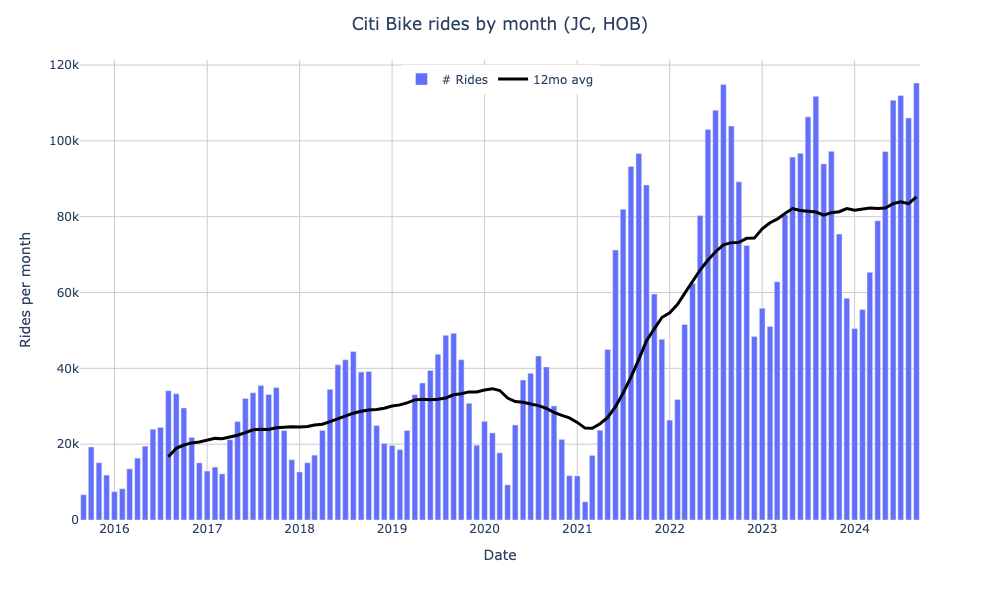

In [10]:
W = 1000
H = 600
plot_title_suffix = "" if regions == all_regions else f" ({', '.join(regions)})"
fig = px.bar(
    rides.rename('# Rides'),
    labels={
        'variable': '',
        'value': 'Rides per month',
    },
).update_layout(
    width=W,
    height=H,
    plot_bgcolor='white',
    xaxis=dict(
        dtick='M12',
    ),
    hovermode='x',
    title=dict(
        x=0.5,
        text=f"Citi Bike rides by month{plot_title_suffix}",
    ),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="center",
        x=0.5,
        orientation="h",
    ),
).update_xaxes(
    gridcolor='#ccc',
    hoverformat=None,
).update_yaxes(
    gridcolor='#ccc',
)
fig.add_trace(
    go.Scatter(
        x=agg_12mo.index,
        y=agg_12mo,
        name='12mo avg',
        line=dict(
            color='black',
            width=3,
        ),
    )
).update_traces(
    hovertemplate='%{y:,}',
)
export(fig, name=f'plot{name_suffix}', id='plot')

In [11]:
MD("Average, annualized change in ridership, over various timeframes:", id="rates")

Average, annualized change in ridership, over various timeframes:

In [12]:
last = agg_12mo.iloc[-1]
months_ago = list(range(12, len(agg_12mo), 12))
n = len(agg_12mo)
if n % 12 != 1:
    months_ago += [n - 1]

change_stats = []
for ma in months_ago:
    rate = (last / agg_12mo.iloc[-1 - ma])**(12/ma) - 1
    avg = agg_12mo.iloc[-1 - ma]
    ya = ma // 12
    ms = ma % 12
    ago_str = f"{ya} year{'' if ya == 1 else 's'}"
    if ms:
        ago_str += f", {ms} months"
    change_stats.append({
        'Duration': ago_str,
        'Start': int(agg_12mo.iloc[-1 - ma]),
        'End': int(last),
        'Avg annual change': (last / agg_12mo.iloc[-1 - ma])**(12/ma) - 1,
        'Total change': last / avg,
    })
    # print(f"Average annual change over {ago_str:5}: {rate:>5.1%} ({int(avg):9,} → {int(last):,}, {last / avg:.2f}x total)")
change_stats = DF(change_stats).set_index('Duration')
export(
    change_stats,
    name=f"rates{name_suffix}",
    fmts={
        'Avg annual change': '.1%',
        'Total change': ',.2f',
    },
    per_page=20,
)

Saved parquet to .ire/rates-jc-hob.parquet
